In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json

## Data

### Setup

In [3]:
PATH = Path('D:/data/carvana')
list(PATH.iterdir())

[WindowsPath('D:/data/carvana/29bb3ece3180_11.jpg'),
 WindowsPath('D:/data/carvana/metadata.csv'),
 WindowsPath('D:/data/carvana/metadata.csv.zip'),
 WindowsPath('D:/data/carvana/models'),
 WindowsPath('D:/data/carvana/sample_submission.csv'),
 WindowsPath('D:/data/carvana/sample_submission.csv.zip'),
 WindowsPath('D:/data/carvana/test'),
 WindowsPath('D:/data/carvana/test.zip'),
 WindowsPath('D:/data/carvana/test_hq'),
 WindowsPath('D:/data/carvana/test_hq.zip'),
 WindowsPath('D:/data/carvana/tmp'),
 WindowsPath('D:/data/carvana/train'),
 WindowsPath('D:/data/carvana/train-128'),
 WindowsPath('D:/data/carvana/train.zip'),
 WindowsPath('D:/data/carvana/train_hq'),
 WindowsPath('D:/data/carvana/train_hq.zip'),
 WindowsPath('D:/data/carvana/train_masks'),
 WindowsPath('D:/data/carvana/train_masks-128'),
 WindowsPath('D:/data/carvana/train_masks-png'),
 WindowsPath('D:/data/carvana/train_masks.csv'),
 WindowsPath('D:/data/carvana/train_masks.csv.zip'),
 WindowsPath('D:/data/carvana/train_

In [4]:
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
TRAIN_DN = 'train'
MASKS_DN = 'train_masks'

In [5]:
masks_csv = pd.read_csv(PATH/MASKS_FN)
masks_csv.head()

,img,rle_mask
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...


In [6]:
meta_csv = pd.read_csv(PATH/META_FN)
meta_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


In [7]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [8]:
CAR_ID = '00087a6bd4dc'

In [9]:
list((PATH/TRAIN_DN).iterdir())[:5]

[WindowsPath('D:/data/carvana/train/00087a6bd4dc_01.jpg'),
 WindowsPath('D:/data/carvana/train/00087a6bd4dc_02.jpg'),
 WindowsPath('D:/data/carvana/train/00087a6bd4dc_03.jpg'),
 WindowsPath('D:/data/carvana/train/00087a6bd4dc_04.jpg'),
 WindowsPath('D:/data/carvana/train/00087a6bd4dc_05.jpg')]

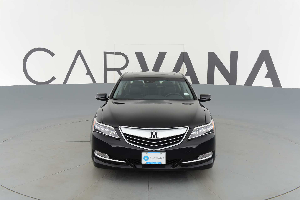

In [10]:
Image.open(PATH/TRAIN_DN/f'{CAR_ID}_01.jpg').resize((300,200))

In [11]:
list((PATH/MASKS_DN).iterdir())[:5]

[WindowsPath('D:/data/carvana/train_masks/00087a6bd4dc_01_mask.gif'),
 WindowsPath('D:/data/carvana/train_masks/00087a6bd4dc_02_mask.gif'),
 WindowsPath('D:/data/carvana/train_masks/00087a6bd4dc_03_mask.gif'),
 WindowsPath('D:/data/carvana/train_masks/00087a6bd4dc_04_mask.gif'),
 WindowsPath('D:/data/carvana/train_masks/00087a6bd4dc_05_mask.gif')]

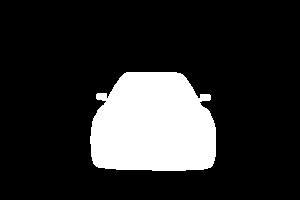

In [12]:
Image.open(PATH/MASKS_DN/f'{CAR_ID}_01_mask.gif').resize((300,200))

In [13]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]

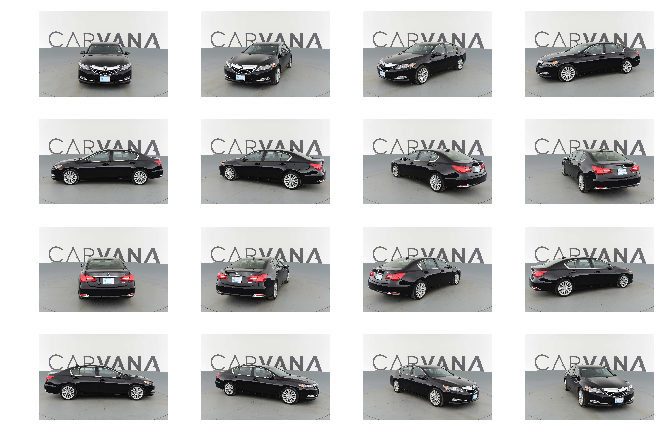

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat): show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

### Resize and convert

In [15]:
(PATH/'train_masks_png').mkdir(exist_ok=True)

In [16]:
def convert_img(fn):
    fn = fn.name
    Image.open(PATH/'train_masks'/fn).save(PATH/'train_masks_png'/f'{fn[:-4]}.png')

In [17]:
files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(convert_img, files)

In [18]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [19]:
def resize_mask(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks_png').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_mask, files)

In [20]:
(PATH/'train-128').mkdir(exist_ok=True)

In [21]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

## Dataset

In [22]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 32

In [23]:
ims = [open_image(PATH/TRAIN_DN/f'{CAR_ID}_{i+1:02d}.jpg') for i in range(16)]
im_masks = [open_image(PATH/MASKS_DN/f'{CAR_ID}_{i+1:02d}_mask.png') for i in range(16)]

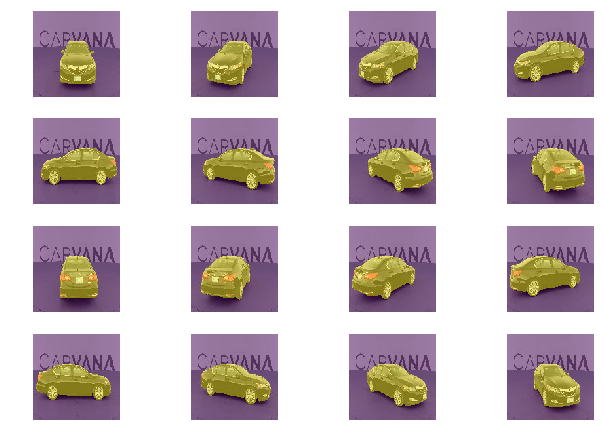

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(9, 6))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [25]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [26]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [27]:
len(x_names)//16//5*16

1008

In [28]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [29]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.PIXEL),
            RandomFlip(tfm_y=TfmType.PIXEL),
            RandomLighting(0.05, 0.05)]
# aug_tfms = []

In [30]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0
    def get_n(self): return len(self.y)

In [31]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)

In [32]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

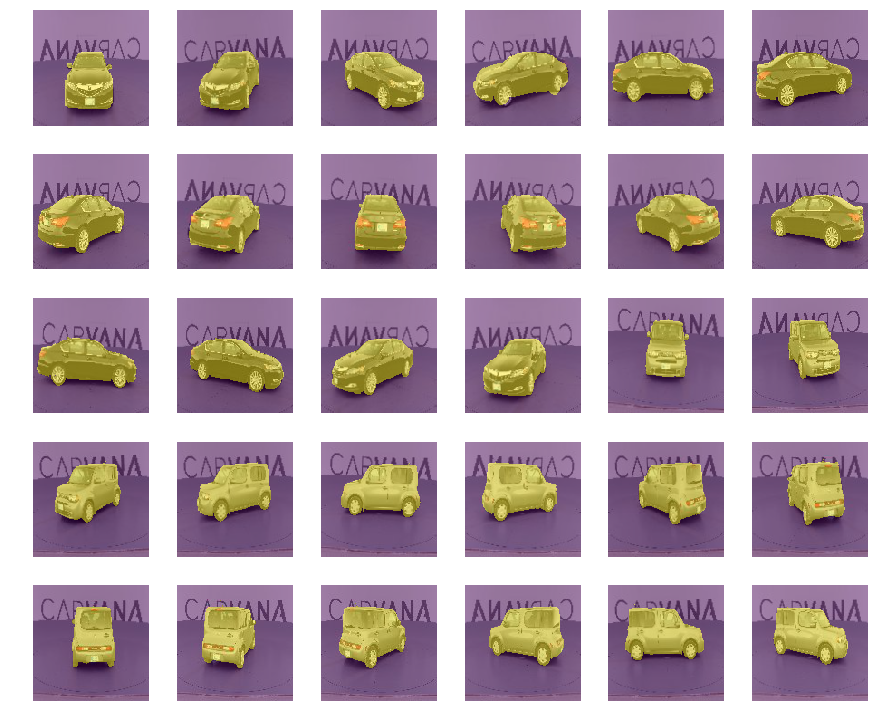

In [33]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

## Model

In [34]:
class Empty(nn.Module): 
    def forward(self,x): return x

models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=Empty())
learn = ConvLearner(md, models)
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [35]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [36]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [37]:
def mask_loss(pred,targ):
    return F.binary_cross_entropy_with_logits(pred[:,0],targ[...,0])

def mask_acc(pred,targ): return accuracy_multi(pred[:,0], targ[...,0], 0.5)

In [38]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 84%|█████████████████████████████████████████████████████████▋           | 107/128 [00:06<00:01, 15.95it/s, loss=2.26]


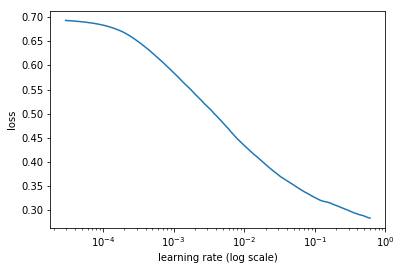

In [39]:
learn.lr_find()
learn.sched.plot()

In [39]:
lr=4e-2

In [41]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.151644   0.149398   0.944488  
    1      0.120412   0.116436   0.947872                                                                              
    2      0.106649   0.101633   0.958022                                                                              
    3      0.098517   0.091158   0.960639                                                                              
    4      0.089892   0.085873   0.960982                                                                              



[0.08587323, 0.960982084274292]

In [42]:
learn.save('tmp')

In [40]:
learn.load('tmp')

In [41]:
py,ay = learn.predict_with_targs()

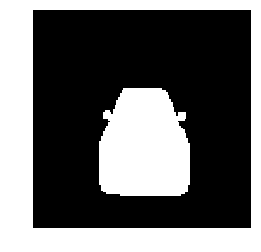

In [42]:
show_img(ay[0]);

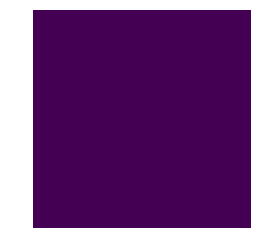

In [43]:
show_img(py[0][0]>0);

In [44]:
learn.unfreeze()

In [45]:
learn.bn_freeze(True)

In [46]:
lrs = np.array([lr/100,lr/10,lr])/4

In [50]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.070019   0.051169   0.976625  
    1      0.058641   0.045506   0.981475                                                                              
    2      0.054193   0.038353   0.983351                                                                              
    3      0.050242   0.040316   0.9811                                                                                
    4      0.044488   0.034384   0.986293                                                                              
    5      0.043618   0.030638   0.986375                                                                              
    6      0.043487   0.029371   0.987156                                                                              
    7      0.043164   0.031652   0.988089                                                                           

[0.019383471, 0.9925659894943237]

In [51]:
learn.save('0')

In [47]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

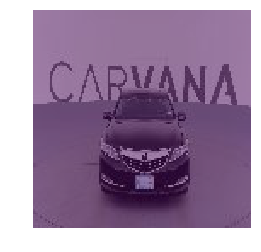

In [48]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

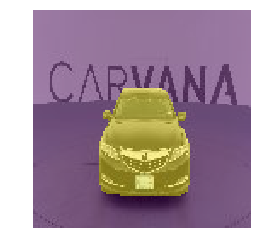

In [49]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 512x512

In [50]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 512
bs = 8

In [51]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [52]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
len(val_x),len(trn_x)

(1008, 4080)

In [53]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=6, classes=None)

In [54]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

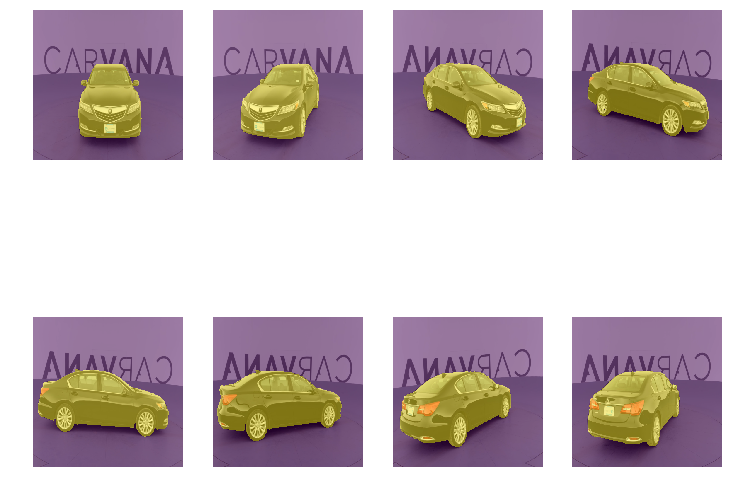

In [55]:
fig, axes = plt.subplots(2, 4, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [56]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [57]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [58]:
learn.load('0')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 77%|████████████████████████████████████████████████████▍               | 393/510 [05:54<01:45,  1.11it/s, loss=0.438]

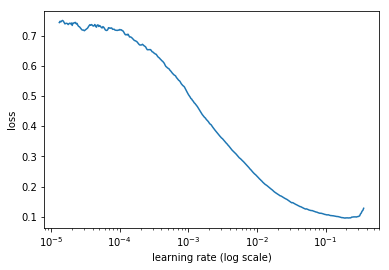

In [56]:
learn.lr_find()
learn.sched.plot()

In [59]:
lr=4e-2

In [66]:
learn.fit(lr,1,cycle_len=5,use_clr=(20,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

  0%|                                                                                          | 0/255 [00:00<?, ?it/s]


Exception in thread Thread-62:
Traceback (most recent call last):
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.048509   0.05004    0.978598  
    1      0.034603   0.039268   0.983321                                                                              
    2      0.036997   0.02898    0.989224                                                                              
    3      0.027607   0.02513    0.991111                                                                              
    4      0.027751   0.02266    0.991754                                                                              



[0.022660363, 0.9917543615613665]

In [67]:
learn.save('tmp')

In [60]:
learn.load('tmp')

In [61]:
learn.unfreeze()
learn.bn_freeze(True)

In [62]:
lrs = np.array([lr/100,lr/10,lr])/4

In [61]:
learn.fit(lrs,1,cycle_len=8,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=8), HTML(value='')))

  0%|                                                                                          | 0/510 [00:00<?, ?it/s]


Exception in thread Thread-13:
Traceback (most recent call last):
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\site-packages\tqdm\_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Klukas\Anaconda3\envs\tensorflow\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.304222   0.130575   0.928763  
    1      0.035723   0.028082   0.989058                                                                              
    2      0.024273   0.01936    0.992003                                                                              
    3      0.023563   0.017159   0.993116                                                                              
    4      0.019377   0.015559   0.994355                                                                              
    5      0.021611   0.014561   0.99443                                                                               
    6      0.023803   0.014803   0.994728                                                                              
    7      0.021992   0.013929   0.994998                                                                           

[0.013928746, 0.994997743576292]

In [62]:
learn.save('512')

In [63]:
learn.load('512')

In [64]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

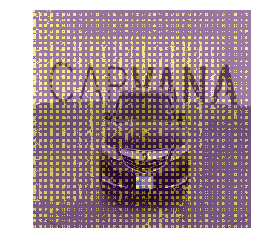

In [67]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

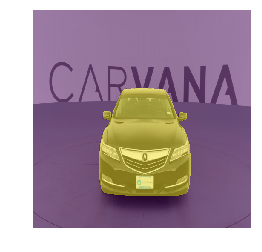

In [68]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

## 1024x1024

In [69]:
sz = 1024
bs = 3

In [70]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=6, classes=None)

In [71]:
denorm = md.trn_ds.denorm
x,y = next(iter(md.aug_dl))
x = denorm(x)

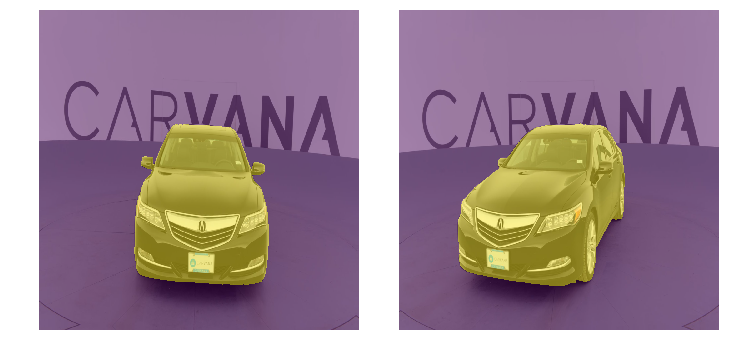

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [73]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
)

In [74]:
models = ConvnetBuilder(resnet34, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=mask_loss
learn.metrics=[mask_acc]

In [75]:
learn.load('512')

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|████████████████████████████████████████████████▉                 | 1008/1360 [13:20<04:39,  1.26it/s, loss=0.296]

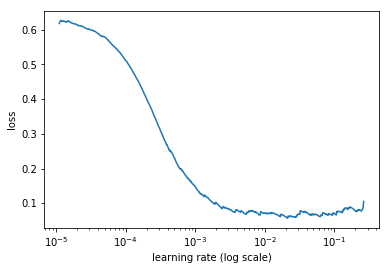

In [74]:
learn.lr_find()
learn.sched.plot()

In [76]:
lr=4e-2

In [77]:
learn.fit(lr,1,cycle_len=2,use_clr=(20,4))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.048183   0.026326   0.990766  
    1      0.050082   0.024805   0.992034                                                                              



[0.024804994, 0.9920343089671362]

In [78]:
learn.save('tmp')

In [79]:
learn.load('tmp')

In [80]:
learn.unfreeze()
learn.bn_freeze(True)

In [81]:
lrs = np.array([lr/100,lr/10,lr])/8

In [82]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.043507   0.014752   0.995689  
    1      0.027913   0.011865   0.996624                                                                              
    2      0.035148   0.012945   0.997036                                                                              
    3      0.038816   0.013434   0.997089                                                                              



[0.013433607, 0.9970886861639363]

In [83]:
learn.fit(lrs,1,cycle_len=40,use_clr=(20,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=40), HTML(value='')))

epoch      trn_loss   val_loss   mask_acc                                                                              
    0      0.035147   0.015548   0.997021  
    1      0.038284   0.01339    0.996775                                                                              
    2      0.099431   0.044639   0.986976                                                                              
    3      0.031756   0.012465   0.99628                                                                               
    4      0.040316   0.015486   0.995587                                                                              
    5      0.047712   0.015716   0.996278                                                                              
    6      0.027799   0.010409   0.996936                                                                              
    7      0.034444   0.016619   0.996499                                                                           

[0.006828854, 0.9977635870732012]

In [84]:
learn.save('1024')

In [85]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

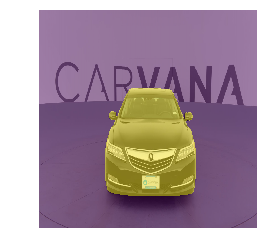

In [86]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

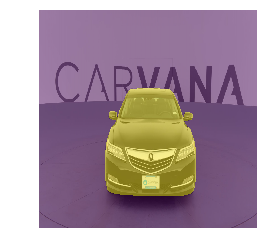

In [87]:
ax = show_img(denorm(x)[0])
show_img(y[0,...,-1], ax=ax, alpha=0.5);

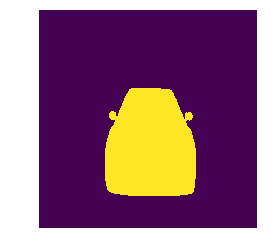

In [88]:
show_img(py[0][0]>0);

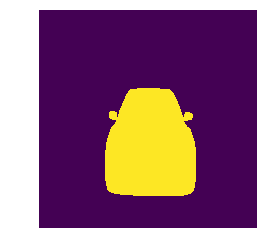

In [89]:
show_img(y[0,...,-1]);

## Fin

In [90]:
x,y = next(iter(md.val_dl))

In [91]:
py = to_np(learn.model(V(x)))

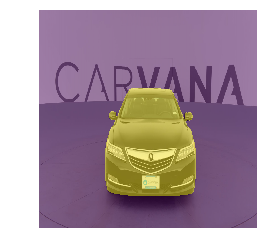

In [92]:
ax = show_img(denorm(x)[0])
show_img(py[0][0]>0, ax=ax, alpha=0.5);

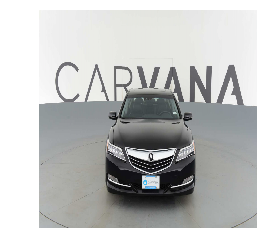

In [93]:
ax = show_img(denorm(x)[0])
